In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from natsort import natsorted

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
img_path = 'data/train/train/images/0001.png'
mask_path = 'data/train/train/masks/0001.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
msk = cv2.imread(mask_path)
msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

img.shape

[ WARN:0@0.050] global loadsave.cpp:241 findDecoder imread_('data/train/train/images/0001.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


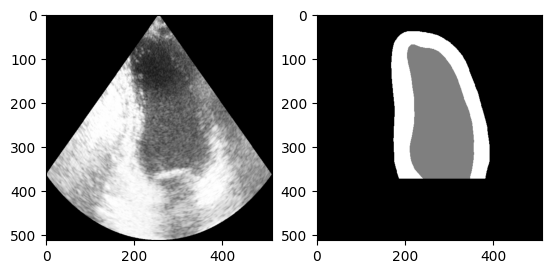

In [4]:
plt.subplot(121)
plt.imshow(img);
plt.subplot(122)
plt.imshow(msk);

In [5]:
np.unique(msk)

array([  0, 127, 255], dtype=uint8)

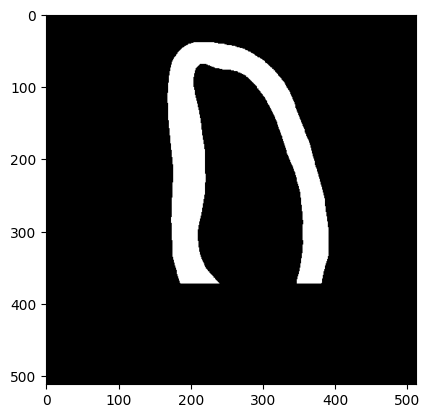

In [6]:
new_msk = np.where(msk == 255, 255, 0)
plt.imshow(new_msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


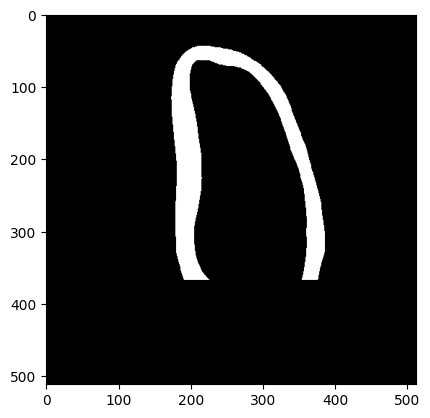

In [7]:
plt.imshow(cv2.erode(new_msk.astype(float), np.ones((11, 11))))

## Read raw data

We have 3 types of input images

- Normal
- nifti
- sequences

In [3]:
camus_path = 'data/raw/CAMUS'
camus_types = [os.path.join(camus_path, dir) for dir in os.listdir(camus_path)]
camus_types

['data/raw/CAMUS/sequences', 'data/raw/CAMUS/nifti', 'data/raw/CAMUS/mhd']

In [4]:
contour = "training"

In [5]:
os.listdir(os.path.join(camus_types[0], contour, 'patient0001'))

['patient0001_2CH_sequence.mhd',
 'patient0001_4CH_sequence.mhd',
 'patient0001_4CH_sequence.raw',
 'patient0001_2CH_sequence.raw']

In [6]:
os.listdir(os.path.join(camus_types[1], contour, 'patient0001'))

['patient0001_2CH_ED.nii.gz',
 'patient0001_4CH_ES.nii.gz',
 'Info_2CH.cfg',
 'patient0001_2CH_ES_gt.nii.gz',
 'patient0001_4CH_ED_gt.nii.gz',
 'patient0001_2CH_half_sequence_gt.nii.gz',
 'MANDATORY_CITATION.md',
 'patient0001_4CH_ED.nii.gz',
 'patient0001_2CH_half_sequence.nii.gz',
 'patient0001_4CH_half_sequence_gt.nii.gz',
 'patient0001_4CH_half_sequence.nii.gz',
 'patient0001_4CH_ES_gt.nii.gz',
 'patient0001_2CH_ED_gt.nii.gz',
 'Info_4CH.cfg',
 'patient0001_2CH_ES.nii.gz']

In [7]:
os.listdir(os.path.join(camus_types[2], contour ,'patient0001'))

['patient0001_2CH_ES.raw',
 'Info_2CH.cfg',
 'patient0001_2CH_ED_gt.mhd',
 'patient0001_2CH_ES_gt.raw',
 'patient0001_4CH_ED_gt.mhd',
 'patient0001_4CH_ES_gt.mhd',
 'patient0001_2CH_ED_gt.raw',
 'patient0001_2CH_ES_gt.mhd',
 'MANDATORY_CITATION.md',
 'patient0001_4CH_ES.mhd',
 'patient0001_2CH_ED.mhd',
 'patient0001_2CH_ES.mhd',
 'patient0001_4CH_ED.mhd',
 'patient0001_4CH_ED_gt.raw',
 'patient0001_2CH_ED.raw',
 'patient0001_4CH_ES.raw',
 'Info_4CH.cfg',
 'patient0001_4CH_ED.raw',
 'patient0001_4CH_ES_gt.raw']

## Open original files

In [8]:
main_path = r'/home/suetin/Docker/Data'
contour = 'testing'

os.path.join(main_path, f"{contour}")

'/home/suetin/Docker/Data/testing'

In [9]:
import numpy as np
# import matplotlib.pyplot as plt
import SimpleITK as sitk

import os# , cv2
from tqdm import tqdm
from natsort import natsorted

import warnings
warnings.filterwarnings('ignore')

In [10]:
def get_filepaths(main_path, img_format='mhd'):  # , as_mask=False):
    
    # Сюда всё запишем
    image_filepaths = []
    mask_filepaths = []
    # Итерируемся по всем пациентам
    for address, dirs, files in os.walk(main_path):
        # Все названия внутри каждого пациента
        for name in files:
            # Выбираем нужный формат
            if img_format in name:
                # Добавляем путь до изображения или маски
                if 'gt' in name and 'sequence' not in name:
                    mask_filepaths.append(os.path.join(address, name))
                if 'gt' not in name and 'sequence' not in name:
                    image_filepaths.append(os.path.join(address, name))
                
    return natsorted(image_filepaths), natsorted(mask_filepaths)

In [11]:
def get_data(paths: list, img_shape=None, as_mask=False):
    """ img_shape - Output image size. Without channels. """
    n_photo = len(paths)      # Batch size
    # if as_mask:
    #     # images = np.empty(shape=(n_photo, img_shape[0], img_shape[1], 1), dtype=np.float16)
    #     images = np.empty(shape=(n_photo, img_shape[0], img_shape[1], 1), dtype=np.float32)
    # else:
    #     images = np.empty(shape=(n_photo, img_shape[0], img_shape[1], 1), dtype=np.float32)
    images = []
    
    for i, path in tqdm(enumerate(paths), total=n_photo):
        # Open mhd
        itk_image = sitk.ReadImage(path)
        image = sitk.GetArrayViewFromImage(itk_image)
        # Reshape
        # image = image.reshape((image.shape[1], image.shape[2], 1))
        # Choose only 1 class from 3  (LV_Endo)
        # if as_mask == True:
        #     image = np.where(image == 1, 1, 0)
        # Resize
        # image = cv2.resize(image.astype(np.uint8), dsize=img_shape, interpolation=cv2.INTER_LINEAR)  # INTER_CUBIC
        
        # Convert to float
        image = image / image.max()  # Transform to 4 classes
        image = (image * 255).astype('uint8')
        # image = image.astype(np.float32)
        if image.ndim == 3:
            image = np.transpose(image, (1, 2, 0))

        # if as_mask:
        #     image = np.where(image == 85, 1, 0)

        images.append(image)
    return images

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 304.98it/s]

[  0  85 170 255]


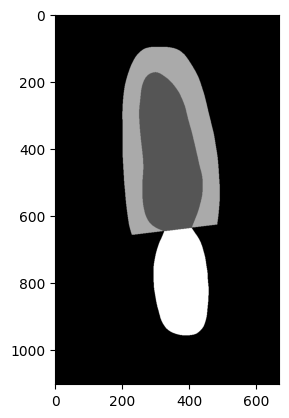

In [12]:
image_paths, mask_paths = get_filepaths(os.path.join(main_path, f"{contour}"))
images = get_data(image_paths, )
masks = get_data(mask_paths, img_shape=None, as_mask=True)

print(np.unique(masks[52]))
plt.imshow(masks[52], 'gray')

(np.float64(-0.5), np.float64(668.5), np.float64(1102.5), np.float64(-0.5))

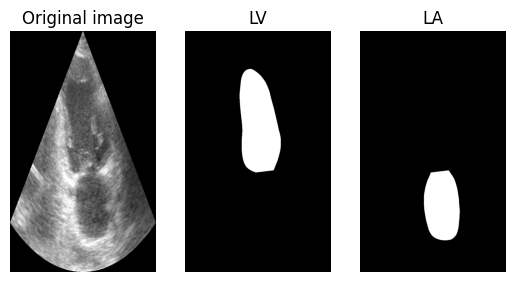

In [13]:
test_LV = np.where(masks[52] == 85, 1, 0) 
test_RV = np.where(masks[52] == 255, 1, 0) 


plt.subplot(131)
plt.imshow(images[52], 'gray')
plt.title("Original image")
plt.axis('off')

plt.subplot(132)
plt.imshow(test_LV, 'gray')
plt.title("LV")
plt.axis('off')

plt.subplot(133)
plt.imshow(test_RV, 'gray')
plt.title('LA')
plt.axis('off')

In [14]:
uniqs = []

for msk in masks:
    uniqs.extend(np.unique(msk))

set(uniqs)

{np.uint8(0), np.uint8(85), np.uint8(170), np.uint8(255)}

In [ ]:
st

In [15]:
def save_data(in_paths: list, out_path:str, mask_type=None, format='mhd'):
    """ We use format due to image have the same name, but they different  """
    n_photo = len(in_paths)      
    # images = []
    
    for path in tqdm(in_paths, total=n_photo):
        # Open mhd
        itk_image = sitk.ReadImage(path)
        image = sitk.GetArrayViewFromImage(itk_image)
        
        # Convert to float
        image = image / image.max()  # Transform to 4 classestrain_img_paths[:5], train_msk_paths[:5]
        image = (image * 255).astype('uint8')
        if image.ndim == 3:
            image = np.transpose(image, (1, 2, 0))
        
        if mask_type == "LV":
            image = np.where(image == 85, 255, 0)
        elif mask_type == "LA":
            image = np.where(image == 255, 255, 0)
        try:
            image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
        except:
            image = cv2.resize(image.astype(np.float32), (512, 512), interpolation=cv2.INTER_CUBIC)

        name = os.path.basename(path)
        name = name.split(".")[0]
        if mask_type:
            cv2.imwrite(os.path.join(out_path, f"{format}_{name}.png"), image)
        else:
            cv2.imwrite(os.path.join(out_path, f"{format}_{name}.jpg"), image)

In [30]:
def save_nii_sequence(in_paths: list, out_path:str, mask=None):
    n_photo = len(in_paths)      
    
    for path in tqdm(in_paths, total=n_photo):
        # Open mhd
        itk_image = sitk.ReadImage(path)
        images = sitk.GetArrayViewFromImage(itk_image)
        
        # Convert to float
        images = images / images.max()  # Transform to 4 classestrain_img_paths[:5], train_msk_paths[:5]
        images = (images * 255).astype('uint8')
        images = np.transpose(images, (1, 2, 0))

        name = os.path.basename(path)
        name = name.split(".")[0]
        # channel == 1 image
        for i in range(images.shape[-1]):
            image = images[:, :, i]
            # print(image.shape)
            if mask == "LA":
                image = np.where(image == 255, 255, 0)
            elif mask == "LV":
                image = np.where(image == 85, 255, 0)
            try:
                image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
            except:
                image = cv2.resize(image.astype(np.float32), (512, 512), interpolation=cv2.INTER_CUBIC)

            if mask:
                cv2.imwrite(os.path.join(out_path, f"nii_{name}_{i}.png"), image)
            else:
                cv2.imwrite(os.path.join(out_path, f"nii_{name}_{i}.jpg"), image)
        # break

In [17]:
# Testing
main_path = 'data/raw/CAMUS/mhd'
out_path = 'data/train/echoLV'
contour = 'testing'
image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='mhd')

save_data(image_paths, os.path.join(out_path, contour, "images"), format='mhd')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LV", format='mhd')

100%|██████████| 200/200 [00:01<00:00, 190.53it/s]


In [18]:
contour = 'training'

image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='mhd')
# training
save_data(image_paths, os.path.join(out_path, contour, "images"), format='mhd')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LV", format='mhd')

100%|██████████| 1800/1800 [00:09<00:00, 198.17it/s]


In [19]:
image_paths[:5], mask_paths[:5]

(['data/raw/CAMUS/nifti/testing/patient0471/patient0471_4CH_ED.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0471/patient0471_4CH_ES.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0471/patient0471_2CH_ED.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0471/patient0471_2CH_ES.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0475/patient0475_2CH_ED.nii.gz'],
 ['data/raw/CAMUS/nifti/testing/patient0471/patient0471_4CH_ES_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0471/patient0471_4CH_ED_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0471/patient0471_2CH_ED_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0471/patient0471_2CH_ES_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0475/patient0475_2CH_ED_gt.nii.gz'])

In [19]:
image_paths[-5:], mask_paths[-5:]

(['data/raw/CAMUS/mhd/training/patient0449/patient0449_4CH_ES.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_2CH_ED.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_2CH_ES.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_4CH_ED.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_4CH_ES.mhd'],
 ['data/raw/CAMUS/mhd/training/patient0449/patient0449_4CH_ES_gt.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_2CH_ED_gt.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_2CH_ES_gt.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_4CH_ED_gt.mhd',
  'data/raw/CAMUS/mhd/training/patient0450/patient0450_4CH_ES_gt.mhd'])

In [20]:
np.unique(masks[0]), masks[0].shape

(array([  0,  85, 170, 255], dtype=uint8), (1102, 669, 1))

In [21]:
main_path = 'data/raw/CAMUS/nifti'
out_path = 'data/train/echoLV'
contour = 'testing'
image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='nii')
# Clear
mask_paths = [msk_path for msk_path in mask_paths if 'sequence_gt' not in msk_path]

save_data(image_paths, os.path.join(out_path, contour, "images"), format='nii')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LV", format='nii')

100%|██████████| 204/204 [00:00<00:00, 290.22it/s]


In [22]:
contour = 'training'

image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='nii')
# Clear
mask_paths = [msk_path for msk_path in mask_paths if 'sequence_gt' not in msk_path]

save_data(image_paths, os.path.join(out_path, contour, "images"), format='nii')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LV", format='nii')

image_paths[:5], mask_paths[:5]

100%|██████████| 1796/1796 [00:06<00:00, 264.02it/s]


(['data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ED.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ES.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ED.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ES.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0002/patient0002_2CH_ED.nii.gz'],
 ['data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ED_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ES_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ED_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ES_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0002/patient0002_2CH_ED_gt.nii.gz'])

100%|██████████| 1/1 [00:00<00:00, 206.17it/s]


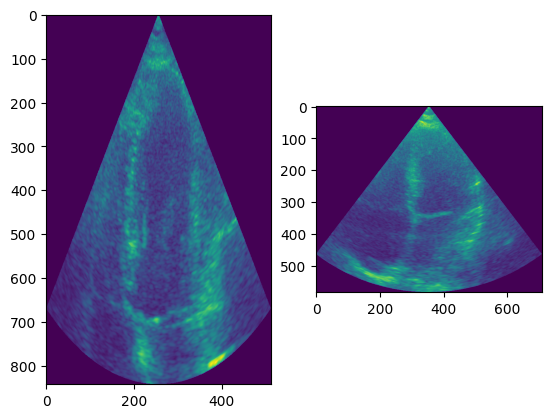

In [23]:
plt.subplot(121)
plt.imshow(get_data(['data/raw/CAMUS/mhd/training/patient0349/patient0349_4CH_ES.mhd'])[0])
plt.subplot(122)
plt.imshow(get_data(['data/raw/CAMUS/nifti/training/patient0349/patient0349_4CH_ES.nii.gz'])[0])

In [24]:
get_data(['data/raw/CAMUS/mhd/training/patient0349/patient0349_4CH_ES.mhd'])[0].shape

100%|██████████| 1/1 [00:00<00:00, 507.17it/s]


(843, 512, 1)

### Sequence

In [41]:
def get_seq_filepaths(main_path, img_format='mhd'):  # , as_mask=False):
    
    # Сюда всё запишем
    image_filepaths = []
    mask_filepaths = []
    # Итерируемся по всем пациентам
    for address, dirs, files in os.walk(main_path):
        # Все названия внутри каждого пациента
        for name in files:
            # Выбираем нужный формат
            if img_format in name:
                # Добавляем путь до изображения или маски
                if 'sequence_gt' in name:
                    mask_filepaths.append(os.path.join(address, name))
                if 'gt' not in name and 'sequence' in name:
                    image_filepaths.append(os.path.join(address, name))
                
    return natsorted(image_filepaths), natsorted(mask_filepaths)

In [42]:
# SEQUENCES
main_path = 'data/raw/CAMUS/nifti'
contour = 'testing'
image_paths, mask_paths = get_seq_filepaths(os.path.join(main_path, contour), img_format='nii')

image_paths[:5], mask_paths[:5]

(['data/raw/CAMUS/nifti/testing/patient0450/patient0450_2CH_half_sequence.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0450/patient0450_4CH_half_sequence.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0451/patient0451_2CH_half_sequence.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0451/patient0451_4CH_half_sequence.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0452/patient0452_2CH_half_sequence.nii.gz'],
 ['data/raw/CAMUS/nifti/testing/patient0450/patient0450_2CH_half_sequence_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0450/patient0450_4CH_half_sequence_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0451/patient0451_2CH_half_sequence_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0451/patient0451_4CH_half_sequence_gt.nii.gz',
  'data/raw/CAMUS/nifti/testing/patient0452/patient0452_2CH_half_sequence_gt.nii.gz'])

In [44]:
save_nii_sequence(image_paths, os.path.join(out_path, contour, "images"), mask=None)
save_nii_sequence(mask_paths, os.path.join(out_path, contour, "masks"), mask="LV")

100%|██████████| 102/102 [00:04<00:00, 21.46it/s]


In [46]:

contour = 'training'
image_paths, mask_paths = get_seq_filepaths(os.path.join(main_path, contour), img_format='nii')


image_paths[:5], mask_paths[:5]

save_nii_sequence(image_paths, os.path.join(out_path, contour, "images"), mask=None)
save_nii_sequence(mask_paths, os.path.join(out_path, contour, "masks"), mask="LV")

100%|██████████| 898/898 [00:48<00:00, 18.33it/s]


## Choose only LV mask

In [100]:
msk = cv2.imread(os.path.join(out_path, contour, "masks", "patient0499_4CH_ED_gt.nii.gz.png"))
msk.shape

(487, 624, 3)

In [101]:
np.unique(msk)

array([  0, 255], dtype=uint8)

## Prepare LA mask

*We have here images and sequence of images in nii format*

In [14]:
main_path = 'data/raw/CAMUS/mhd'
out_path = 'data/train/echoLA'
contour = 'testing'

image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='mhd')

save_data(image_paths, os.path.join(out_path, contour, "images"), format='mhd')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LA", format='mhd')

100%|██████████| 200/200 [00:00<00:00, 228.25it/s]


In [16]:
contour = 'training'

image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='mhd')

save_data(image_paths, os.path.join(out_path, contour, "images"), format='mhd')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LA", format='mhd')

100%|██████████| 1800/1800 [00:07<00:00, 243.59it/s]


In [28]:
main_path = 'data/raw/CAMUS/nifti'
contour = 'testing'
image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='nii')
# Clear
image_paths = [img_path for img_path in image_paths if 'sequence' not in img_path]
mask_paths = [msk_path for msk_path in mask_paths if 'sequence_gt' not in msk_path]

save_data(image_paths, os.path.join(out_path, contour, "images"), format='nii')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LA", format='nii')

100%|██████████| 204/204 [00:00<00:00, 301.39it/s]


In [36]:
len(image_paths), len(mask_paths), image_paths[:5], mask_paths[:5]

(0, 0, [], [])

In [29]:
contour = 'training'

image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='nii')
# Clear
image_paths = [img_path for img_path in image_paths if 'sequence' not in img_path]
mask_paths = [msk_path for msk_path in mask_paths if 'sequence_gt' not in msk_path]

save_data(image_paths, os.path.join(out_path, contour, "images"), format='nii')
save_data(mask_paths, os.path.join(out_path, contour, "masks"), mask_type="LA", format='nii')

image_paths[:5], mask_paths[:5]

100%|██████████| 1796/1796 [00:06<00:00, 266.28it/s]


(['data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ED.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ES.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ED.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ES.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0002/patient0002_2CH_ED.nii.gz'],
 ['data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ED_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_2CH_ES_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ED_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0001/patient0001_4CH_ES_gt.nii.gz',
  'data/raw/CAMUS/nifti/training/patient0002/patient0002_2CH_ED_gt.nii.gz'])

In [35]:
# SEQUENCES
main_path = 'data/raw/CAMUS/nifti'
contour = 'testing'
image_paths, mask_paths = get_seq_filepaths(os.path.join(main_path, contour), img_format='nii')

image_paths[:5], mask_paths[:5]

([], [])

In [44]:
save_nii_sequence(image_paths, os.path.join(out_path, contour, "images"), mask=None)
save_nii_sequence(mask_paths, os.path.join(out_path, contour, "masks"), mask="LA")

100%|██████████| 102/102 [00:04<00:00, 21.63it/s]


In [32]:
# SEQUENCES
main_path = 'data/raw/CAMUS/nifti'
contour = 'training'
image_paths, mask_paths = get_seq_filepaths(os.path.join(main_path, contour), img_format='nii')

image_paths[:5], mask_paths[:5]

save_nii_sequence(image_paths, os.path.join(out_path, contour, "images"), mask=None)
save_nii_sequence(mask_paths, os.path.join(out_path, contour, "masks"), mask="LA")

0it [00:00, ?it/s]
  0%|          | 0/1796 [00:00<?, ?it/s]


ValueError: axes don't match array

In [ ]:
# was 3596, become 20 997 ??????